# 变分量子精密测量

<em> Copyright (c) 2022 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

量子精密测量通过利用量子理论（如量子纠缠）来研究如何高精度和高灵敏度测量物理参数，其理论方面为量子参数估计理论，应用方面为量子传感。已有研究表明，利用量子理论估计的参数精度相较于经典方法有开根号的提升 [1-3]。对于一个未知参数，量子精密测量的目标就是最大化参数估计精度的同时最小化所需要的资源（如时间、量子比特数等）。

例如，给定一个酉算子 $e^{-i\phi H}$，其中 $H$ 是给定的哈密顿量，那么如何用量子精密测量的方法估计未知参数 $\phi$ 呢？主要包括以下四步：
1. 初始化：制备系统初始输入态 $|\psi\rangle$;
2. 参数化：输入态在 $e^{-i\phi H}$ 的演化下得到参数化的量子态 $e^{-i\phi H}|\psi\rangle$；
3. 测量：测量输入态经过含有未知参数演化后得到的输出态；
4. 经典估计：根据多次测量的结果估计未知参数的值。

结合量子参数估计理论的知识，本教程根据 [4] 中变分量子传感的思想，利用量桨构建变分量子电路训练损失函数，得到能够估计服从正态分布的参数的传感器，即优化后的量子电路。

## 参数估计理论

### 经典参数估计

经典参数估计，如最大似然估计（maximum-likelihood estimator, MLE），通过利用多个样本来计算包含未知参数信息的数据，即给定一个含有未知参数 $\phi$ 的概率分布，$f$ 为概率密度函数，${\bf X}=\{X_1,X_2,...,X_N\}$ 为 $N$ 个独立同分布的样本数据，利用 MLE 得到 $\phi$ 的估计值 $\hat\phi$：

$$
\hat\phi({\bf X})=\arg\max_{\phi}\prod_i^Nf(X_i,\phi), \tag{1}
$$

即求一个 $\phi$ 使得 $X_i(i=1,...,N)$ 同时出现的概率最大。在得到估计的参数后，如何衡量估计得到的参数与实际参数的差距呢？即如何衡量估计参数的精度？参数估计理论中一般利用均方误差（mean squared error, MSE）来衡量这一精度。

含有未知参数 $\bf{\phi}$ 的样本为 ${\bf{X}}=\{X_1,X_2,...,X_N\}\in \mathcal F^N$，${\mathcal F}^N$ 为样本空间，假设 $\hat{\phi}({\bf X}):{\mathcal F}^N\rightarrow\Phi$ 为估计 $\phi\in\Phi$ 的估计器（$\Phi$ 为参数空间），则 $\hat{\phi}({\bf X})$ 关于 $\phi$ 的均方误差定义为

$$
\begin{aligned}
\rm{MSE}&=E[(\hat{\phi}({\bf X})-\phi)^2]\\
&=\sum_{{\bf X}\in {\mathcal F}^N}f({\bf X};\phi)(\hat{\phi}({\bf X})-\phi)^2, \tag{2}
\end{aligned}
$$

其中 $f({\bf X};\phi)$ 为给定参数后的得到当前样本 $\bf X$ 的概率密度。尽管不同的估计器会影响 MSE 的值，但不论 $\hat{\phi}({\bf X})$ 的选择如何，都有 ${\rm{MSE}}\geq\frac{1}{N{\mathcal I}(\phi)}$，该式被称为 Cramér–Rao (CR) 界 [2]，其中 ${\mathcal I}(\phi)$ 为费舍信息，用于描述参数变化对分布影响的物理量（关于费舍信息在量桨上的应用可参见教程[量子费舍信息](https://qml.baidu.com/tutorials/qnn-research/quantum-fisher-information.html)）。

### 量子参数估计

在量子参数估计中，经典参数估计中利用的一组样本变成了待测的量子态 $\rho_{\phi}\in{\mathcal F}({\mathcal H})$，其中 $\phi$ 为未知参数，${\mathcal F}({\mathcal H})$ 表示希尔伯特空间 $\mathcal H$ 上的密度算子集。根据量子精密测量的四步及文献 [4]，假设初始输入态为 $|0\rangle$，估计器为 $\hat{\phi}(m)$（$m$ 与测量结果有关，例如为测量得到的比特串中 1 和 0 的个数差），其关于待估计参数 $\phi$ 的均方误差为

$$
\begin{aligned}
{\rm MSE}&=E[(\hat{\phi}(m)-\phi)^2]\\
&=\sum_m(\hat{\phi}(m)-\phi)^2p(m|\phi),
\end{aligned} \tag{3}
$$

其中 $p(m|\phi)$ 为给定参数 $\phi$ 时测量得到 $m$ 的概率。同样的，不论 $\hat{\phi}(m)$ 如何选择，有量子 CR 界 ${\rm{MSE}}\geq\frac{1}{NF(\phi)}$，其中 $N$ 为重复测量 $\rho_\phi$ 的次数，$F(\phi)$ 为量子费舍信息（关于量子费舍信息在量桨上的应用可参见教程[量子费舍信息](https://qml.baidu.com/tutorials/qnn-research/quantum-fisher-information.html)）。

## 变分量子传感

量子传感属于量子精密测量的应用，本教程依据文献 [4]，主要介绍一类变分拉姆塞干涉仪。传统的拉姆塞干涉仪 [2]（如图 1）是一种利用磁共振现象测量粒子跃迁频率的粒子干涉测量法，被用于测量未知参数；变分拉姆塞干涉仪 [6]（如图 2）是在电路编码和解码部分设置两个参数化量子电路（记为 $U_{\rm{En}}(\theta_{\rm En}), U_{\rm{De}}(\theta_{\rm{De}})$），用于设置纠缠和测量量子态。已有研究表明，结合量子理论（如量子纠缠），估计参数的精度由 $O(\frac{1}{\sqrt N})$ 提高到 $O(\frac{1}{N})$ [1-3]，而通过变分的方式可以有效地找到合适的纠缠方式。

![Ramsey_interferomertry](./figures/QM-fig-RI.png "图1：拉姆塞干涉仪。")

图 1 所示为拉姆塞干涉仪估计参数的过程 [2]。左图是拉姆塞干涉仪的经典设定方式，右图为使用了量子纠缠的拉姆塞干涉仪。相比于经典设定，使用量子纠缠后的干涉仪在估计未知参数的精度上有开根号的优势。

![V_Ramsey_interferomertry](./figures/QM-fig-V_RI3.png "图2：变分拉姆塞干涉仪。")

图 2 所示为变分拉姆塞干涉仪。其中两个参数化量子电路通过优化找到电路有效的纠缠方式。

下面我们利用量桨搭建参数化量子电路，来研究利用变分拉姆塞干涉仪估计的服从正态分布的参数的精度。主要分为以下三步：
1. 初始化；
2. 评估；
3. 优化。

参数服从的正态分布的概率密度函数为：

$$
f(x)=\frac{1}{\sqrt{2\pi}\nu}\exp(-\frac{(x-\mu)^2}{2\nu^2}), \tag{4}
$$

$\mu$ 为均值，$\nu^2$ 为方差。此时变分拉姆塞干涉仪的损失函数为：

$$
C(\theta_{\rm En},\theta_{\rm De},a)=\int d\phi f(\phi){\rm{MSE}}(\phi), \tag{5}
$$

其中选择的估计器为 $\hat\phi(m)=am$，$a$ 为需要优化的参数，$m$ 为测量得到的比特串中 1 和 0 的个数差，MSE 为 ${\rm MSE}(\phi)=\sum_m(\hat{\phi}(m)-\phi)^2p_{\theta}(m|\phi)$，$\theta=(\theta_{\rm En},\theta_{\rm De})$。

### 1. 初始化

- 设置 $|0\rangle$ 为初始输入态；
- 设置编码和解码部分的参数化量子电路 $U_{\rm{En}}，U_{\rm{De}}$；
- 将未知参数编码至电路中。

我们在量桨中实现上述过程，首先引入需要的包：

In [1]:
import numpy as np
from math import exp, pi
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List

import paddle
import paddle_quantum as pq
from paddle_quantum.ansatz import Circuit
from paddle_quantum.loss import Measure

pq.set_backend('state_vector')
pq.set_dtype('complex128')

接下来我们构建 $N$ 量子比特的参数化量子电路完成初始化操作。
<!-- 其中未知参数服从正态分布，其概率密度函数为：
$$
f(x)=\frac{1}{\sqrt{(2\pi)}\sigma}exp(-\frac{(x-\mu)^2}{2\sigma^2}),
$$
本教程中，我们选择 $\mu=0,\sigma=1$。 -->
整个电路包括以下五部分：
- $R_y^{\otimes N}(\frac{\pi}{2})$ 门；
- 编码电路 $U_{\rm{En}}(\theta_{\rm{En}})$；
- 含有未知参数的 $R_z^{\otimes N}(\phi)=e^{-i\phi J_z}$，其中 $J_z=\frac{1}{2}\sum_{k=1}^N\sigma_z^{(k)}$， $\sigma_z^{(k)}$ 表示作用在第 $k$ 个量子比特上的泡利 $Z$ 算符；
- 解码电路 $U_{\rm{De}}(\theta_{\rm{De}})$；
- $R_x^{\otimes N}(\frac{\pi}{2})$ 门。

因此整个电路的酉算子可以由
$$
U(\phi,\theta_{\rm{En}},\theta_{\rm{De}})=R_x^{\otimes N}(\frac{\pi}{2})U_{\rm{De}}(\theta_{\rm{De}})R_z^{\otimes N}(\phi)U_{\rm{En}}(\theta_{\rm{En}})R_y^{\otimes N}(\frac{\pi}{2}) \tag{6}
$$
来表示，当编码电路和解码电路的电路层数为 $0$ 时，此时的电路即为经典设定下的拉姆塞干涉仪。下面我们搭建编码和解码电路。

In [2]:
def RamseyCircuit(theta_EN: paddle.Tensor, theta_DE: paddle.Tensor, input_phi: float) -> Circuit:
    r""" 构建拉姆塞干涉仪的变分电路
    
    Args:
        theta_EN: 编码层参数, shape 为 [编码层深度，比特数，3]
        theta_DE: 解码层参数, shape 为 [解码层深度，比特数，3]
        input_phi: 未知参数输入
    
    Returns:
        创建完成的参数化量子电路
    
    """
    depth_EN, depth_DE = theta_EN.shape[0], theta_DE.shape[0]
    num_qubits = theta_EN.shape[1]
    
    cir = Circuit(num_qubits)
    cir.ry(param=pi/2)
    
    # 搭建编码电路，生成存在纠缠的输入态
    for depth in range(depth_EN):
        cir.u3(param=theta_EN[depth])
        cir.cnot()
    
    # 未知参数门
    cir.rz(param=input_phi)
    
    # 搭建解码电路，旋转测量基
    for depth in range(depth_DE):
        cir.cnot()
        cir.u3(param=theta_DE[depth])
        
    cir.rx(param=pi/2)
    return cir

### 2. 评估

- 计算测量结果 $m$ 的概率分布；
- 计算估计器 $\hat{\phi}(m)=am$ 的 MSE，${\rm MSE}=\sum_m(\hat{\phi}(m)-\phi)^2p_{\theta}(m|\phi)$；
- 计算损失函数，此处我们利用离散形式的损失函数来近似其积分形式：

$$
C=\sum_{k=1}^t\frac{2}{t}f(\phi_k){\rm {MSE}}, \tag{7}
$$

其中 $t$ 为选取区间内划分的份数（本教程中区间大小为 2），$f(\phi_k)$ 为 $\phi_k$ 对应的概率。

In [3]:
# 定义计算 m 的函数用于计算测量结果中 1 和 0 的个数差
def calculate_m(num_qubits: int)-> List[int]:
    m_list = []
    for k in range(2**num_qubits):
        k_bin = list(bin(k)[2:].zfill(num_qubits))
        u = k_bin.count('1')
        v = k_bin.count('0')
        m = u - v
        m_list.append(m)

    return m_list


def MSE(qnn: paddle.nn.Layer, phi: float) -> paddle.Tensor:
    r""" 计算对应 phi 的 MSE
    
    Args:
        cir: 拉姆塞干涉仪的变分电路
        phi: 采样参数
        a: 估计器的优化参数
        
    Returns:
        phi 的均方误差
    
    """
    cir = RamseyCircuit(qnn.theta_EN, qnn.theta_DE, phi)
    
    # 测量
    output_state = cir()
    prob = Measure()(output_state)
    
    num_qubits = cir.num_qubits
    m = calculate_m(num_qubits)
    return sum([((phi - qnn.a * m[i]) ** 2) * prob[i] for i in range(2 ** num_qubits)])

# 定义损失函数
def loss_func(qnn: paddle.nn.Layer, sampling_times: int, mean: float, variance: float):
    r""" 计算 QNN 模型的损失函数
    
    Args:
        qnn: 一个 QNN 模型
        sampling_times: 划分区间的个数
        mean: 未知参数服从的正态分布的均值
        variance: 未知参数服从的正态分布的方差
    
    """
    list_phi = [] # phi 的采样列表
    list_pdf = [] # phi 的概率密度函数样本
    for i in range(sampling_times):
        phi = mean - 1 + (2 * i + 1)/ sampling_times # phi 的范围 [u - 1, u + 1]，每个 phi 取小区间端点处两个 phi 的均值       
        prob = (1 / (((2 * pi) ** 0.5) * variance)) * exp(-((phi - mean) ** 2) / (2 * (variance**2)))  # phi 的概率密度函数
        list_phi.append(phi)
        list_pdf.append(prob)
    
    return sum([list_pdf[i] * MSE(qnn, list_phi[i]) * (2 / sampling_times) for i in range(sampling_times)])

### 3. 优化

In [4]:
def optimization(qnn: paddle.nn.Layer, num_itr: int, learning_rate: float) -> None:
    r""" 对 QNN 模型进行优化
    
    Args:
        qnn: 一个 QNN 模型
        num_itr: 迭代次数
        learning_rate: 学习速率
    
    """
    opt = paddle.optimizer.Adam(learning_rate=learning_rate, parameters=qnn.parameters())
    print("训练开始：")
    for itr in range(1, num_itr):
        loss = qnn()
        loss.backward()
        opt.minimize(loss)
        opt.clear_grad()

        if itr % 10 == 0:
            print("     iter:", itr, "loss:", "%.4f" % loss.numpy())

In [6]:
class RamseyInterferometer(paddle.nn.Layer):
    r""" 变分拉姆塞干涉仪
    
    """
    def __init__(self) -> None:
        super().__init__()
        
        # 为干涉仪添加参数
        theta_EN = self.create_parameter(
            shape= [depth_EN, N, 3], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        theta_DE = self.create_parameter(
            shape= [depth_DE, N, 3], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        self.add_parameter('theta_EN', theta_EN)
        self.add_parameter('theta_DE', theta_DE)
        
        # 添加对估计器的优化参数
        a = self.create_parameter(
            shape= [1], dtype="float64",
            default_initializer=paddle.nn.initializer.Uniform(low=0, high=2 * pi),
        )
        self.add_parameter('a', a)
        
    def forward(self) -> paddle.Tensor:
        r""" 计算损失函数
        
        """
        return loss_func(self, TIMES, MEAN, VAR)
    
    def opt(self) -> None:
        r""" 优化 QNN 模型
        
        """
        optimization(self, num_itr=ITR, learning_rate=LR)

In [ ]:
N = 2  # 量子比特数
depth_EN = 3  # 编码电路的层数
depth_DE = 3  # 解码电路的层数
LR = 0.2  # 基于梯度下降的优化方法的学习率
ITR = 150   # 训练的总迭代次数
TIMES = 30  # 划分参数区间的个数
MEAN = 2  # 未知参数服从正态分布的均值
VAR = 1  # 未知参数服从正态分布的方差

In [11]:
QNN = RamseyInterferometer()
QNN.opt()

训练开始：
     iter: 10 loss: 5.6798
     iter: 20 loss: 2.3396
     iter: 30 loss: 1.1354
     iter: 40 loss: 0.8429
     iter: 50 loss: 0.4878
     iter: 60 loss: 0.3399
     iter: 70 loss: 0.2571
     iter: 80 loss: 0.2270
     iter: 90 loss: 0.2140
     iter: 100 loss: 0.2067
     iter: 110 loss: 0.2031
     iter: 120 loss: 0.2013
     iter: 130 loss: 0.2001
     iter: 140 loss: 0.1994


利用优化后的电路估计服从正态分布的参数 $\phi$，绘制 MSE。

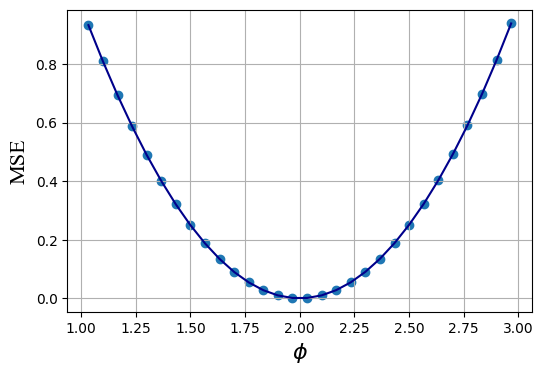

In [12]:
phi_list = []
mse_list = []
for i in range(TIMES):
    phi = MEAN - 1 + (2 * i + 1) / TIMES
    mse_est = MSE(QNN, phi)
    phi_list.append(phi)
    mse_list.append(mse_est)

font = {'family': 'Times New Roman', 'weight':'normal', 'size':16}
plt.figure(dpi=100)
plt.plot(phi_list,mse_list,color='darkblue', linestyle='-')
plt.scatter(phi_list,mse_list)
plt.xlabel('$\\phi$',font)
plt.ylabel('MSE',font)

plt.grid()
plt.show()

## 结论

从图中可以看到，优化后的量子传感器（即量子电路）估计服从正态分布的参数的 MSE 与参数的概率密度呈负相关（MSE 与 $\phi$ 的图像呈下凸型），且 MSE 在正态分布的均值（即 $\mu$ 的取值）附近最低，说明在均值附近传感器估计参数的精度高，进一步说明通过变分的方式得到的传感器对该服从正态分布的参数有效。

---

## 参考文献

[1] Braunstein S L, Caves C M. Statistical distance and the geometry of quantum states[J]. [Physical Review Letters, 1994, 72(22): 3439](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.72.3439).

[2] Giovannetti V, Lloyd S, Maccone L. Quantum metrology[J]. [Physical review letters, 2006, 96(1): 010401](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.96.010401).

[3] Tóth G, Apellaniz I. Quantum metrology from a quantum information science perspective[J]. [Journal of Physics A: Mathematical and Theoretical, 2014, 47(42): 424006](https://iopscience.iop.org/article/10.1088/1751-8113/47/42/424006/meta).

[4] Marciniak C D, Feldker T, Pogorelov I, et al. Optimal metrology with programmable quantum sensors[J]. [Nature, 2022, 603(7902): 604-609](https://www.nature.com/articles/s41586-022-04435-4).

[5] Giovannetti V, Lloyd S, Maccone L. Advances in quantum metrology[J]. [Nature photonics, 2011, 5(4): 222-229](https://www.nature.com/articles/nphoton.2011.35).

[6] Kaubruegger R, Vasilyev D V, Schulte M, et al. Quantum variational optimization of Ramsey interferometry and atomic clocks[J]. [Physical Review X, 2021, 11(4): 041045](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.11.041045).